**Create and validate 31-day running mean climatology for ERA-5 v1.1 tas, tmax, tmin.**

In [3]:
! pip install git+https://github.com/ClimateImpactLab/xclim.git@qdm_add_year_selection

  Cloning https://github.com/ClimateImpactLab/xclim.git (to revision qdm_add_year_selection) to /tmp/pip-req-build-kcqtg4l1
  Using cached boltons-20.2.1-py2.py3-none-any.whl (170 kB)
  Using cached cftime-1.4.1-cp38-cp38-manylinux2014_x86_64.whl (322 kB)
  Created wheel for xclim: filename=xclim-0.24.0-py3-none-any.whl size=272391 sha256=176fc8de43fb917e7c0a0c04ad8c976bb13d54b97c7614cc64fd8a1d7b07cfc1
  Stored in directory: /tmp/pip-ephem-wheel-cache-g2pmv8dl/wheels/d3/2a/fd/4b118244d4c312a9c161b6964c50e3f3df8091188478abbba0
Successfully built xclim
  Attempting uninstall: cftime
    Found existing installation: cftime 1.3.0
    Uninstalling cftime-1.3.0:
      Successfully uninstalled cftime-1.3.0


In [4]:
%matplotlib inline

import xarray as xr
import numpy as np
import os as os
import matplotlib.pyplot as plt
from cartopy import config
import cartopy.crs as ccrs
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import pandas as pd
import itertools
import datetime 
import toolz
from datetime import date
from pathlib import Path, PurePath
from xclim.core.calendar import convert_calendar

import sys

import dask.distributed as dd
import dask
import rhg_compute_tools.kubernetes as rhgk

In [5]:
client, cluster = rhgk.get_big_cluster()
cluster.scale(10)

In [6]:
client

Client Scheduler: gateway://traefik-impactlab-hub-dask-gateway.impactlab-hub:80/impactlab-hub.3370cb2404d7461cafc8a13a0183cfb0 Dashboard: /services/dask-gateway/clusters/impactlab-hub.3370cb2404d7461cafc8a13a0183cfb0/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [43]:
cluster.close()

In [7]:
yrs = np.arange(1994,2016) 

In [8]:
def pull_ERA5_variable(variable):
    filenames = []
    
    for num_yrs in range(len(yrs)):
        filename = '/gcs/impactlab-data/climate/source_data/ERA-5/{}/daily/netcdf/v1.1/{}_daily_{}-{}.nc'.format(variable, variable, yrs[num_yrs], yrs[num_yrs])
        filenames.append(filename)
    
    era5_var = xr.open_mfdataset(filenames, 
                               concat_dim='time', combine='by_coords')
    
    var_all = era5_var[variable]
    
    return var_all


In [9]:
da = pull_ERA5_variable('tas')

In [10]:
da = da.persist()

In [11]:
# remove leap days and convert calendar to no-leap
da = convert_calendar(da, 'noleap')

/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [12]:
def assign_coords(da):
    years = np.arange(da.time.dt.year.min(),da.time.dt.year.max()+1)
    
    da_wcoords = da.assign_coords(dayofyear=xr.DataArray(np.array([np.arange(1,366)]*len(years)).flatten(),
                                                dims=('time'),
                                                coords={'time':da.time})).persist()
    return da_wcoords

In [13]:
da = assign_coords(da)

In [14]:
da_dayofyear_mean = da.sel(time=slice('1994-12-17','2015-01-15')).groupby('dayofyear').mean().persist()

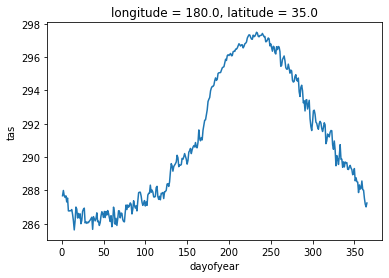

In [15]:
da_dayofyear_mean.sel(latitude=35.0,longitude=180.0).plot()

In [16]:
da_dayofyear_mean.nbytes / (1024**3)

1.4117270708084106

In [17]:
da_dayofyear_mean = da_dayofyear_mean.load()

In [18]:
def rolling_31day_mean(da):
    roll = da.pad(dayofyear=15, mode='wrap').rolling(dayofyear=31, center=True).mean().dropna('dayofyear')
    return roll

In [36]:
da_rolling_mean = rolling_31day_mean(da_dayofyear_mean)
da_rolling_mean

<xarray.DataArray 'tas' (dayofyear: 365, latitude: 721, longitude: 1440)>
array([[[249.17253, 249.17253, 249.17253, ..., 249.17253, 249.17253,
         249.17253],
        [249.11324, 249.11343, 249.11368, ..., 249.11267, 249.11288,
         249.11305],
        [249.15422, 249.15468, 249.15518, ..., 249.15271, 249.15305,
         249.15352],
        ...,
        [247.4847 , 247.48412, 247.48363, ..., 247.48619, 247.48586,
         247.48543],
        [247.39037, 247.39015, 247.38988, ..., 247.39081, 247.39064,
         247.39053],
        [247.18474, 247.18474, 247.18474, ..., 247.18474, 247.18474,
         247.18474]],

       [[249.06825, 249.06825, 249.06825, ..., 249.06825, 249.06825,
         249.06825],
        [249.00575, 249.00598, 249.00623, ..., 249.00516, 249.0054 ,
         249.00555],
        [249.04488, 249.04536, 249.04591, ..., 249.04327, 249.04366,
         249.04414],
...
        [247.44392, 247.44344, 247.44275, ..., 247.44542, 247.44518,
         247.4446 ],
        [247.34982, 247.34964, 247.34935, ..., 247.35034, 247.35036,
         247.35011],
        [247.14468, 247.14468, 247.14468, ..., 247.14468, 247.14468,
         247.14468]],

       [[249.26051, 249.26051, 249.26051, ..., 249.26051, 249.26051,
         249.26051],
        [249.19513, 249.19531, 249.19545, ..., 249.19437, 249.19472,
         249.195  ],
        [249.22823, 249.22864, 249.2292 , ..., 249.22638, 249.22675,
         249.22728],
        ...,
        [247.478  , 247.47751, 247.47685, ..., 247.4795 , 247.47926,
         247.47868],
        [247.38335, 247.38315, 247.38287, ..., 247.38387, 247.38388,
         247.38362],
        [247.17834, 247.17834, 247.17834, ..., 247.17834, 247.17834,
         247.17834]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365

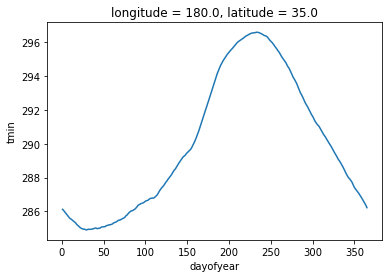

In [108]:
da_rolling_mean.sel(latitude=35.0,longitude=180.0).plot()

Before creating the netcdf file, run a quick validation of the climatology. 

In [38]:
def test_for_nans(da):
    # no nans
    assert da.isnull().sum() == 0, "there are nans!"

def test_temp_range(da):
    # make sure temp values are in a valid range
    # asserts if statement below is false
    assert (da.min() > 150) or (ds[var].max() < 350), "temperature values are invalid" 

In [39]:
test_for_nans(da_rolling_mean)

In [40]:
test_temp_range(da_rolling_mean)

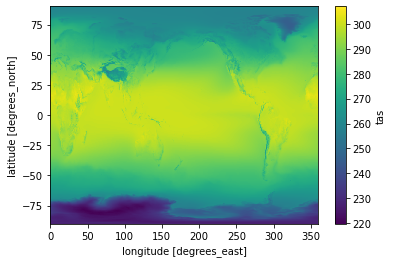

In [41]:
da_rolling_mean.mean(dim='dayofyear').plot()

In [109]:
def create_netcdf(da, variable):
    '''
    create netcdf file.
    '''
    out_direc = ('/gcs/impactlab-data/climate/source_data/ERA-5/{}/climatology/'.format(variable))
    out_filename = ('{}_1995_2015_climo.nc'.format(variable))
    
    if not Path(out_direc).exists():
                    Path(out_direc).mkdir(parents=True, exist_ok=True)
            
    # add attributes to dataset and save file 
    attrsdt = {
        'author': 'Meredith Fish',
        'contact': 'meredith.fish@rutgers.edu',
        'project': ('downscaling CMIP6'),
        'source': ('/gcs/climate/source_data/ERA-5/day/tmin/v1.1'),
        'method': ('31-rolling mean climatology, no leap days'),
        'created': str(date.today()),
        'units': 'K'}

    da.attrs.update(attrsdt)
    
    # save file
    da.to_netcdf(Path(PurePath(out_direc).joinpath(out_filename)))

In [79]:
create_netcdf(da_rolling_mean, 'tas')

**Validation back for the `pad` function**

In [23]:
validate_pad = da_dayofyear_mean.sel(latitude=35.0,longitude=180.0).pad(dayofyear=15, mode='wrap')
validate_pad[:15]

<xarray.DataArray 'tas' (dayofyear: 15)>
array([288.57297, 288.7557 , 288.51685, 288.49692, 287.86853, 288.32697,
       288.07523, 288.12262, 288.56268, 288.04086, 288.0148 , 287.5272 ,
       287.17526, 287.00854, 287.24033], dtype=float32)
Coordinates:
    longitude  float32 180.0
    latitude   float32 35.0
  * dayofyear  (dayofyear) int64 351 352 353 354 355 356 ... 361 362 363 364 365

In [26]:
validate_pad[365:380]

<xarray.DataArray 'tas' (dayofyear: 15)>
array([288.57297, 288.7557 , 288.51685, 288.49692, 287.86853, 288.32697,
       288.07523, 288.12262, 288.56268, 288.04086, 288.0148 , 287.5272 ,
       287.17526, 287.00854, 287.24033], dtype=float32)
Coordinates:
    longitude  float32 180.0
    latitude   float32 35.0
  * dayofyear  (dayofyear) int64 351 352 353 354 355 356 ... 361 362 363 364 365

In [29]:
validate_pad[15:30]

<xarray.DataArray 'tas' (dayofyear: 15)>
array([287.6764 , 287.99368, 287.68512, 287.57724, 287.6733 , 287.30478,
       287.53952, 286.768  , 286.76416, 286.7729 , 286.78256, 286.8471 ,
       286.55835, 286.17303, 285.62436], dtype=float32)
Coordinates:
    longitude  float32 180.0
    latitude   float32 35.0
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15

In [30]:
validate_pad[380:]

<xarray.DataArray 'tas' (dayofyear: 15)>
array([287.6764 , 287.99368, 287.68512, 287.57724, 287.6733 , 287.30478,
       287.53952, 286.768  , 286.76416, 286.7729 , 286.78256, 286.8471 ,
       286.55835, 286.17303, 285.62436], dtype=float32)
Coordinates:
    longitude  float32 180.0
    latitude   float32 35.0
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15

the `pad` function should wrap the last values to the beginning and the beginning values to the end. Given the original dataset of 1-365 we then add 15 days from the end to the beginning, which match the 351-365 days. Additionally, the 1-15 days match the days at the end of the new 'padded' `DataArray`. `Pad` function is validated.

**Validation for the `rolling` function**

In [31]:
validate_roll = da_dayofyear_mean.sel(latitude=35.0,longitude=180.0).rolling(dayofyear=31, center=True).mean().dropna('dayofyear')
validate_roll

<xarray.DataArray 'tas' (dayofyear: 335)>
array([286.731  , 286.67883, 286.61926, 286.5717 , 286.5305 , 286.489  ,
       286.4359 , 286.3999 , 286.38464, 286.3654 , 286.35016, 286.3459 ,
       286.3223 , 286.30908, 286.30005, 286.31406, 286.3236 , 286.31458,
       286.30548, 286.30658, 286.31042, 286.31107, 286.31552, 286.33243,
       286.35184, 286.348  , 286.3313 , 286.30536, 286.31937, 286.30954,
       286.31262, 286.3418 , 286.3619 , 286.35608, 286.35962, 286.3465 ,
       286.34323, 286.37933, 286.39014, 286.39188, 286.40704, 286.41724,
       286.40436, 286.40488, 286.40356, 286.42932, 286.46362, 286.47626,
       286.48932, 286.50204, 286.52484, 286.54135, 286.56708, 286.56247,
       286.57324, 286.5922 , 286.60782, 286.62668, 286.6571 , 286.66635,
       286.71603, 286.7724 , 286.8014 , 286.84024, 286.89487, 286.92633,
       286.96527, 286.99554, 287.01517, 287.025  , 287.05576, 287.07062,
       287.10614, 287.15686, 287.21136, 287.2825 , 287.321  , 287.3499 ,
       287.38376, 287.39957, 287.41916, 287.43726, 287.46698, 287.50168,
       287.53534, 287.5548 , 287.56348, 287.57422, 287.6027 , 287.62668,
       287.66232, 287.66724, 287.66916, 287.67038, 287.67407, 287.6972 ,
       287.73285, 287.76953, 287.81085, 287.86652, 287.94852, 288.01883,
       288.08514, 288.14032, 288.19476, 288.25217, 288.29703, 288.36865,
       288.43127, 288.4805 , 288.54224, 288.60397, 288.6654 , 288.722  ,
       288.7744 , 288.8513 , 288.94003, 289.017  , 289.0956 , 289.1521 ,
...
       297.13712, 297.11636, 297.0817 , 297.04507, 297.02704, 297.00668,
       296.99268, 296.96967, 296.94086, 296.88248, 296.82254, 296.76953,
       296.72186, 296.68365, 296.63727, 296.57516, 296.5099 , 296.44406,
       296.38458, 296.3204 , 296.24976, 296.18472, 296.12833, 296.05283,
       295.97116, 295.887  , 295.81415, 295.75827, 295.6879 , 295.62332,
       295.5714 , 295.4831 , 295.38715, 295.32007, 295.25946, 295.17432,
       295.0712 , 294.96603, 294.8422 , 294.74817, 294.68356, 294.5992 ,
       294.51242, 294.42987, 294.3082 , 294.18066, 294.05872, 293.95624,
       293.8753 , 293.78616, 293.69702, 293.6023 , 293.49905, 293.39014,
       293.2955 , 293.21527, 293.13782, 293.04755, 292.9433 , 292.8438 ,
       292.75363, 292.66693, 292.60303, 292.5116 , 292.40787, 292.3134 ,
       292.22693, 292.16077, 292.09952, 292.06158, 292.0022 , 291.91455,
       291.83643, 291.76553, 291.66956, 291.57846, 291.5222 , 291.46707,
       291.38486, 291.2976 , 291.2308 , 291.14355, 291.07175, 290.9867 ,
       290.91928, 290.84628, 290.77167, 290.69156, 290.6146 , 290.53558,
       290.462  , 290.38617, 290.3036 , 290.21985, 290.16946, 290.10382,
       290.0273 , 289.96283, 289.8778 , 289.7898 , 289.69052, 289.59103,
       289.49866, 289.42966, 289.3364 , 289.26178, 289.2323 , 289.16626,
       289.10596, 289.04053, 288.94714, 288.82657, 288.742  ],
      dtype=float32)
Coordinates:
    longitude  float32 180.0
    latitude   float32 35.0
  * dayofyear  (dayofyear) int64 16 17 18 19 20 21 ... 345 346 347 348 349 350

In [32]:
validate_roll.sel(dayofyear=20)

<xarray.DataArray 'tas' ()>
array(286.5305, dtype=float32)
Coordinates:
    longitude  float32 180.0
    latitude   float32 35.0
    dayofyear  int64 20

In [34]:
validate_roll_v2 = da_dayofyear_mean.sel(dayofyear=slice(5,35),latitude=35.0,longitude=180.0)
validate_roll_v2

<xarray.DataArray 'tas' (dayofyear: 31)>
array([287.6733 , 287.30478, 287.53952, 286.768  , 286.76416, 286.7729 ,
       286.78256, 286.8471 , 286.55835, 286.17303, 285.62436, 286.1628 ,
       286.99637, 286.87726, 286.33826, 286.61432, 286.3466 , 286.59088,
       285.9958 , 286.18625, 286.73538, 286.87216, 286.93216, 286.04498,
       286.12067, 286.01764, 286.0878 , 286.0603 , 286.14713, 286.21072,
       286.29962], dtype=float32)
Coordinates:
    longitude  float32 180.0
    latitude   float32 35.0
  * dayofyear  (dayofyear) int64 5 6 7 8 9 10 11 12 ... 28 29 30 31 32 33 34 35

In [35]:
validate_roll_v2.mean()

<xarray.DataArray 'tas' ()>
array(286.53052, dtype=float32)
Coordinates:
    longitude  float32 180.0
    latitude   float32 35.0

Rolling mean given the 31-day window is the same as selecting the 31-days independently. The `rolling` function works as expected.

Given the code first `pads` the `da`, the `dropna` flag only drops the extra padded days once they are no longer needed as they are only used to average days 1-15 and 350-365. The end result of padding and rolling should be an array of 1-365.